
# 1D Inversion of for a Single Sounding

Here we use the module *simpeg.electromangetics.frequency_domain_1d* to invert
frequency domain data and recover a 1D electrical conductivity model.
In this tutorial, we focus on the following:

    - How to define sources and receivers from a survey file
    - How to define the survey
    - Sparse 1D inversion of with iteratively re-weighted least-squares

For this tutorial, we will invert 1D frequency domain data for a single sounding.
The end product is layered Earth model which explains the data. The survey
consisted of a vertical magnetic dipole source located 30 m above the
surface. The receiver measured the vertical component of the secondary field
at a 10 m offset from the source in ppm.


## Import modules




In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from discretize import TensorMesh

import simpeg.electromagnetics.frequency_domain as fdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

# sphinx_gallery_thumbnail_number = 2

## Download Test Data File

Here we provide the file path to the data we plan on inverting.
The path to the data file is stored as a
tar-file on our google cloud bucket:
"https://storage.googleapis.com/simpeg/doc-assets/em1dfm.tar.gz"




In [2]:
# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/em1dfm.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
data_filename = dir_path + "em1dfm_data.txt"

overwriting C:\Users\iscre\work\classes\GPGN486\FDEM_Project_FC_2025\SimPEG_examples\em1dfm.tar.gz
   saved to: C:\Users\iscre\work\classes\GPGN486\FDEM_Project_FC_2025\SimPEG_examples\em1dfm.tar.gz
Download completed!


## Load Data and Plot

Here we load and plot the 1D sounding data. In this case, we have the
secondary field response in ppm for a set of frequencies.




array([  778.,   797.,  1230.,  1490.,  1770.,  4060.,  4410., 11800.])

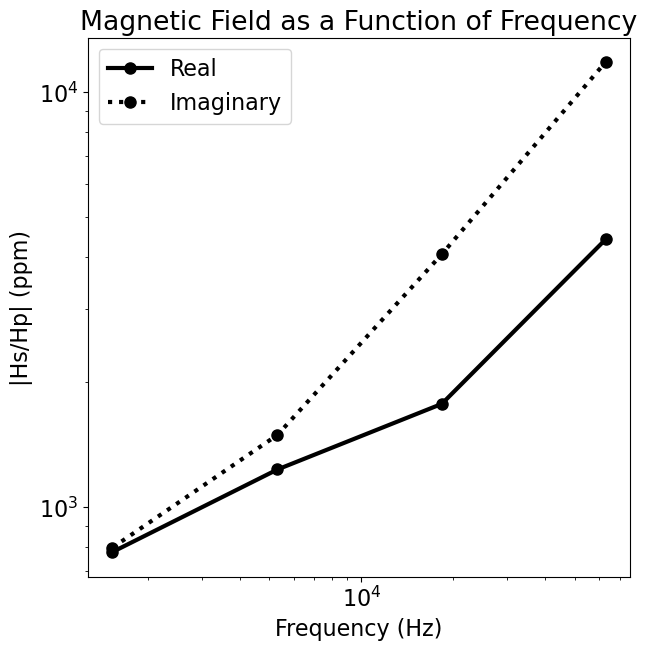

In [3]:
# Data import
df = pd.read_csv('../data/gem2_combined.csv')

# Visualization of one point
# Choses the first survey point
dobs = np.empty(0)
#frequencies = [450, 1530, 5310, 18330, 63030]
frequencies = [1530, 5310, 18330, 63030]
for i in range(len(frequencies)):
    dobs = np.append(dobs, df.loc[0][f'I_{frequencies[i]}Hz [ppm]'])
    dobs = np.append(dobs, df.loc[0][f'Q_{frequencies[i]}Hz [ppm]'])

# Define receiver locations and observed data
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.loglog(frequencies, np.abs(dobs[0::2]), "k-o", lw=3)
ax.loglog(frequencies, np.abs(dobs[1::2]), "k:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Magnetic Field as a Function of Frequency")
ax.legend(["Real", "Imaginary"])
dobs

## Defining the Survey

Here we demonstrate a general way to define the receivers, sources and survey.
The survey consisted of a vertical magnetic dipole source located 30 m above the
surface. The receiver measured the vertical component of the secondary field
at a 10 m offset from the source in ppm.




In [4]:
source_location = np.array([-0.8, 0.0, 0.15])
moment = 3.0

receiver_location = np.array([0.8, 0.0, 0.15])
receiver_orientation = "z"
data_type = "ppm"

# Receiver list
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define source list
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation="z",
            moment=moment,
        )
    )

# Survey
survey = fdem.survey.Survey(source_list)

## Assign Uncertainties and Define the Data Object

Here is where we define the data that are inverted. The data are defined by
the survey, the observation values and the uncertainties.




In [5]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

## Defining a 1D Layered Earth (1D Tensor Mesh)

Here, we define the layer thicknesses for our 1D simulation. To do this, we use
the TensorMesh class.




In [6]:
# Layer thicknesses
inv_thicknesses = np.logspace(0, 0.1, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")
inv_thicknesses

array([1.        , 1.00964028, 1.01937349, 1.02920053, 1.0391223 ,
       1.04913973, 1.05925373, 1.06946522, 1.07977516, 1.09018449,
       1.10069417, 1.11130517, 1.12201845, 1.13283502, 1.14375586,
       1.15478198, 1.1659144 , 1.17715414, 1.18850223, 1.19995972,
       1.21152766, 1.22320712, 1.23499917, 1.2469049 , 1.25892541])

## Define a Starting and/or Reference Model and the Mapping

Here, we create starting and/or reference models for the inversion as
well as the mapping from the model space to the active cells. Starting and
reference models can be a constant background value or contain a-priori
structures. Here, the starting model is log(0.1) S/m.

Define log-conductivity values for each layer since our model is the
log-conductivity. Don't make the values 0!
Otherwise the gradient for the 1st iteration is zero and the inversion will
not converge.



In [7]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(0.1 * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

## Define the Physics using a Simulation Object




In [8]:
simulation = fdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

## Define Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem





In [9]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(mesh, mapping=reg_map, alpha_s=0.025, alpha_x=1.0)

# reference model
reg.reference_model = starting_model

# Define sparse and blocky norms p, q
reg.norms = [0, 0]

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=150, maxIterLS=120, maxIterCG=130, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [10]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Directive for the IRLS
update_IRLS = directives.UpdateIRLS(max_irls_iterations=130, irls_cooling_factor=1.5)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights()

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [11]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.81e+03  1.64e+03  0.00e+00  1.64e+03    2.15e+03      0              


C:\Users\iscre\anaconda3\envs\FC25\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Pardiso. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


   1  4.41e+03  8.45e+02  1.64e-02  9.18e+02    3.21e+02      0              
   2  2.20e+03  4.88e+02  6.38e-02  6.28e+02    1.12e+02      0   Skip BFGS  
   3  1.10e+03  2.09e+02  1.28e-01  3.51e+02    6.99e+01      0              
   4  5.51e+02  6.27e+01  1.79e-01  1.61e+02    4.67e+01      0              
   5  2.75e+02  1.98e+01  2.16e-01  7.91e+01    2.76e+01      0   Skip BFGS  
   6  1.38e+02  9.59e+00  2.37e-01  4.23e+01    1.78e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 5.073001550848163
   7  1.38e+02  6.11e+00  3.09e-01  4.86e+01    1.22e+01      0   Skip BFGS  
   8  1.38e+02  7.43e+00  3.90e-01  6.11e+01    1.43e+01      0              
   9  8.47e+01  1.00e+01  4.37e-01  4.71e+01    8.31e+00      0              
  10  5.24e+01  9.83e+00  4.76e-01  3.48e+01    6.88e+00      0              
  11  3.31e+01  9.38e+00  4.75e-01  2.51e+01    7.20e+00      0   Skip BFGS  
  12  2.08e+01  7.93e+00  4.39e-01 

## Plotting Results




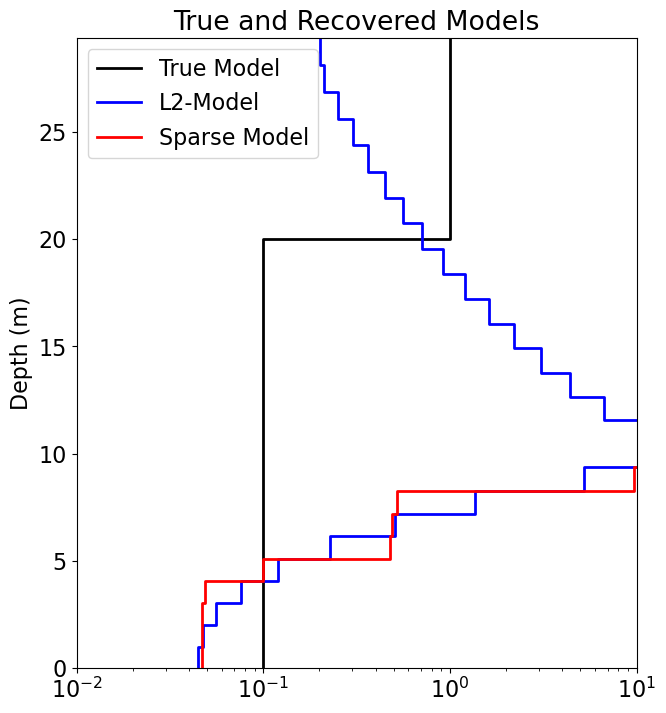

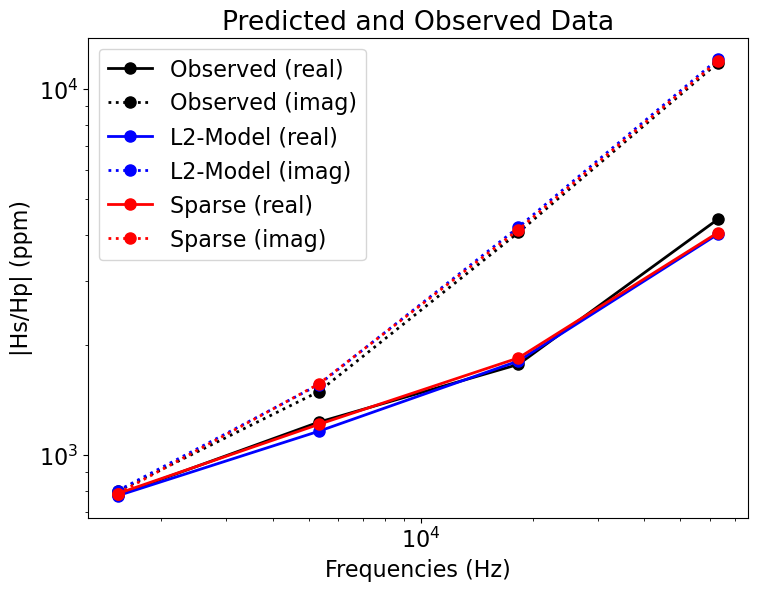

In [13]:
# Load the true model and layer thicknesses
true_model = np.array([0.1, 1.0, 0.1])
true_layers = np.r_[20.0, 40.0, 160.0]

# Extract Least-Squares model
l2_model = inv_prob.l2model

# Plot true model and recovered model
fig = plt.figure(figsize=(8, 9))
x_min = np.min(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)
x_max = np.max(
    np.r_[model_mapping * recovered_model, model_mapping * l2_model, true_model]
)

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_model, ax=ax1, show_layers=False, color="k")
plot_1d_layer_model(
    mesh.h[0], model_mapping * l2_model, ax=ax1, show_layers=False, color="b"
)
plot_1d_layer_model(
    mesh.h[0], model_mapping * recovered_model, ax=ax1, show_layers=False, color="r"
)
ax1.set_xlim(0.01, 10)
ax1.set_title("True and Recovered Models")
ax1.legend(["True Model", "L2-Model", "Sparse Model"])
plt.gca().invert_yaxis()

# Plot predicted and observed data
dpred_l2 = simulation.dpred(l2_model)
dpred_final = simulation.dpred(recovered_model)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(frequencies, np.abs(dobs[0::2]), "k-o")
ax1.loglog(frequencies, np.abs(dobs[1::2]), "k:o")
ax1.loglog(frequencies, np.abs(dpred_l2[0::2]), "b-o")
ax1.loglog(frequencies, np.abs(dpred_l2[1::2]), "b:o")
ax1.loglog(frequencies, np.abs(dpred_final[0::2]), "r-o")
ax1.loglog(frequencies, np.abs(dpred_final[1::2]), "r:o")
ax1.set_xlabel("Frequencies (Hz)")
ax1.set_ylabel("|Hs/Hp| (ppm)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    [
        "Observed (real)",
        "Observed (imag)",
        "L2-Model (real)",
        "L2-Model (imag)",
        "Sparse (real)",
        "Sparse (imag)",
    ],
    loc="upper left",
)
plt.show()